In [1]:
!pip install darts

  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730985 sha256=319b6c65245e88040b9b6cab49dcaf40f24100424ffb536cd45126aa744c9b92
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\a0\8b\b2\810ae5a6f970c8be4725353400d643c90de1c0f023a9884ee7
Successfully built pymeeus
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2


In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [29]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [30]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [31]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [32]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [33]:
train_data = train_data[train_data['TurbID']==21]

In [35]:
train_data = train_data[['Day','Tmstamp','Wspd']]

In [36]:
train_data.head()

,Day,Tmstamp,Wspd
576000,1,00:00,5.46
576001,1,00:10,5.46
576002,1,00:20,5.11
576003,1,00:30,4.80
576004,1,00:40,4.74


In [23]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Patv"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp.drop(["Day"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y

In [37]:
# time stamp label encoding
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x))

#train_x, train_y = make_train_data(train_data)

In [38]:
train_data.head()

,Day,Tmstamp,Wspd
576000,1,0,5.46
576001,1,1,5.46
576002,1,2,5.11
576003,1,3,4.80
576004,1,4,4.74


# acf, pacf

비정상성을 제거하는 모델 ARIMA

- p : AR이 몇번째 까지 과거를 보는지
- d : 차분에 대한 파라미터
- q:  MR이 몇번째 과거까지 보는지

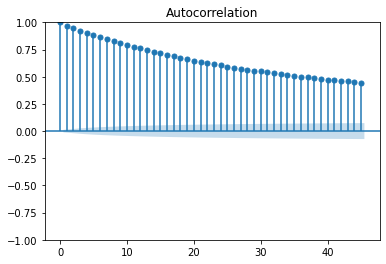

In [43]:
plot_acf(train_data['Wspd'])
plt.show()

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


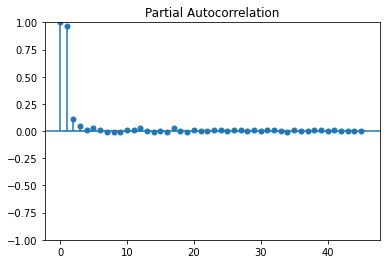

In [44]:
plot_pacf(train_data['Wspd'])
plt.show()